In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from gensim.models import nmf, ldamodel
import gensim.models.phrases
from gensim.matutils import corpus2dense
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import train_test_split
from scipy import sparse
import pyLDAvis
import pyLDAvis.gensim_models
import pickle
from joblib import parallel_backend
from sklearn.feature_extraction.text import CountVectorizer
from project_functions.utils import picklify, unpickle, dataframe_to_sparse
from project_functions.EDA import create_gensim_dictionaries, obtain_gensim_sparse, sparse_gensim_to_dataframe
from project_functions.EDA import obtain_sklearn_bag_of_words, create_pyLDAvis, perform_tsne_analysis
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet('../data/cleaned/tokenized_data_complete.parquet')
genres_to_keep = df.genre_name.value_counts()[df.genre_name.value_counts() > 3000].index.values.tolist()
df = df.loc[df.genre_name.isin(genres_to_keep)].copy()
# df.to_parquet('../data/cleaned/tokenized_data_large_genres.parquet')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.lyrics.to_frame(), df.genre_name,
                                                    test_size = 0.2, random_state = 42, stratify = df.genre_name)
# picklify(y_train, '../data/cleaned/train/y_train.pickle')
# picklify(y_test, '../data/cleaned/test/y_test.pickle')

## Vectorization

In [5]:
texts, phrasers, corpora, dictionaries = create_gensim_dictionaries(X_train, n_gram_depth = 4)
picklify(texts, '../data/gensim/gensim_texts.pickle')
picklify(phrasers, '../data/gensim/gensim_phrasers.pickle')
picklify(corpora, '../data/gensim/gensim_corpora.pickle')
picklify(dictionaries, '../data/gensim/gensim_dictionaries.pickle')

In [6]:
X_train_gensim_2gram_sparse, X_test_gensim_2gram_sparse =\
            obtain_gensim_sparse(X_train, X_test, phrasers[0], dictionaries[0])
picklify(X_train_gensim_2gram_sparse, '../data/cleaned/train/X_train_gensim_2gram_sparse.pickle')
picklify(X_test_gensim_2gram_sparse, '../data/cleaned/test/X_test_gensim_2gram_sparse.pickle')

In [7]:
X_train_gensim_3gram_sparse, X_test_gensim_3gram_sparse =\
            obtain_gensim_sparse(X_train, X_test, phrasers[1], dictionaries[1])
picklify(X_train_gensim_3gram_sparse, '../data/cleaned/train/X_train_gensim_3gram_sparse.pickle')
picklify(X_test_gensim_3gram_sparse, '../data/cleaned/test/X_test_gensim_3gram_sparse.pickle')

In [8]:
X_train_gensim_4gram_sparse, X_test_gensim_4gram_sparse =\
            obtain_gensim_sparse(X_train, X_test, phrasers[2], dictionaries[2])
picklify(X_train_gensim_4gram_sparse, '../data/cleaned/train/X_train_gensim_4gram_sparse.pickle')
picklify(X_test_gensim_4gram_sparse, '../data/cleaned/test/X_test_gensim_4gram_sparse.pickle')

In [5]:
vtr = CountVectorizer()
vtr_args = {'min_df': 0.05, 'max_df': 0.95}
X_train_count_unigrams, X_test_count_unigrams = obtain_sklearn_bag_of_words(X_train, X_test,
                                                                          vtr, vectorizer_args = vtr_args)
picklify(X_train_count_unigrams, '../data/cleaned/train/X_train_count_unigrams.pickle')
picklify(X_test_count_unigrams, '../data/cleaned/test/X_test_count_unigrams.pickle')

In [6]:
vtr = CountVectorizer()
vtr_args = {'min_df': 0.05, 'max_df': 0.95, 'ngram_range': (1, 2)}
X_train_count_bigrams, X_test_count_bigrams = obtain_sklearn_bag_of_words(X_train, X_test,
                                                                          vtr, vectorizer_args = vtr_args)
picklify(X_train_count_bigrams, '../data/cleaned/train/X_train_count_bigrams.pickle')
picklify(X_test_count_bigrams, '../data/cleaned/test/X_test_count_bigrams.pickle')

## Topic Modeling

In [7]:
coherences_nmf = []
for i in range(4,20):
    nmf = Nmf(corpus, num_topics = i, normalize = True, random_state = 42)
    cm = CoherenceModel(model = nmf, corpus = corpus, texts = texts, dictionary = dct, coherence = 'c_v')
    coherence = cm.get_coherence()  # get coherence value
    coherences_nmf.append((i, coherence))


/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/josh/.local/lib/python3.8/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.c

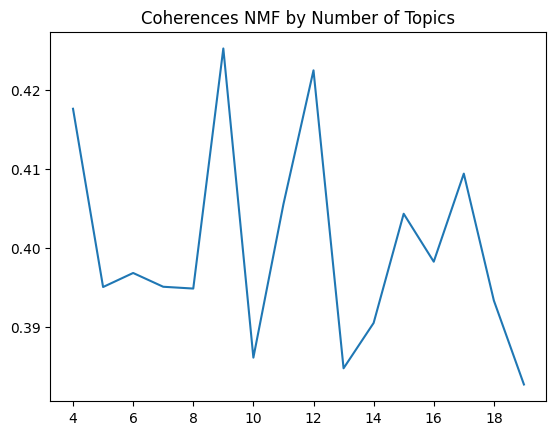

In [10]:
plt.plot([i[0] for i in coherences_nmf], [i[1] for i in coherences_nmf])
plt.title('Coherences NMF by Number of Topics');

In [11]:
coherences_lda = []
for i in range(4,20):
    lda = LdaModel(corpus, num_topics = i, random_state = 42)
    cm = CoherenceModel(model = lda, corpus = corpus, texts = texts, dictionary = dct, coherence = 'c_v')
    coherence = cm.get_coherence()  # get coherence value
    coherences_lda.append((i, coherence))

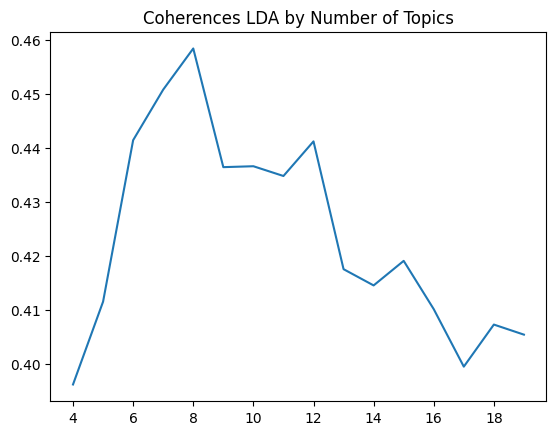

In [12]:
plt.plot([i[0] for i in coherences_lda], [i[1] for i in coherences_lda])
plt.title('Coherences LDA by Number of Topics');

In [25]:
coherences_lda_trigrams = []
with parallel_backend('loky', n_jobs = -1):
    for i in range(6,14):
        lda = LdaModel(corpora[1], num_topics = i, random_state = 42)
        cm = CoherenceModel(model = lda, corpus = corpora[1], texts = texts[1],
                            dictionary = dictionaries[1], coherence = 'c_v')
        coherence = cm.get_coherence()  # get coherence value
        coherences_lda_trigrams.append((i, coherence))

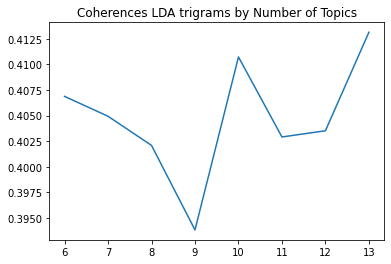

In [26]:
plt.plot([i[0] for i in coherences_lda_trigrams], [i[1] for i in coherences_lda_trigrams])
plt.title('Coherences LDA trigrams by Number of Topics');

In [12]:
lda_best = LdaModel(corpus, num_topics = 8, random_state = 42)
p = create_pyLDAvis(lda_best, corpus, dct, plot = True, save = True,
                    save_dest = '../visualizations/pyLDAvis/pyLDAvis_lda_8.html')
p

/home/josh/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.177339  0.012639       1        1  22.049277
7      0.081964 -0.108262       2        1  19.816609
3      0.024206 -0.051176       3        1  16.934928
2      0.092688 -0.112037       4        1  13.144400
5     -0.151065  0.045035       5        1   9.771175
0     -0.056122 -0.052854       6        1   7.675535
6     -0.278377  0.018236       7        1   5.641988
1      0.109367  0.248419       8        1   4.966088, topic_info=     Term          Freq         Total Category  logprob  loglift
250  love  51824.000000  51824.000000  Default  30.0000  30.0000
61    get  44817.000000  44817.000000  Default  29.0000  29.0000
375   god   9858.000000   9858.000000  Default  28.0000  28.0000
84   life  20986.000000  20986.000000  Default  27.0000  27.0000
191  lord   7226.000000   7226.000000  Default  26.0000  26.0000
..    ...           ...           ...      ...      ...      ...
250  love    849.328015  51824.526597   Topic8  -5.1480  -1.1086
303  feel    718.850281  21909.774569   Topic8  -5.3148  -0.4145
168   say    709.103462  24602.794486   Topic8  -5.3284  -0.5441
228  want    592.154159  19033.087531   Topic8  -5.5087  -0.4676
181   bad    524.315586   3918.958725   Topic8  -5.6303   0.9911

[717 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6904      6  0.968760         ___
6904      8  0.026910         ___
8599      1  0.998264       aaaah
8880      6  0.992412    abnormal
6917      2  0.970103  absolutely
...     ...       ...         ...
805       3  0.000724         yuh
805       6  0.000362         yuh
805       7  0.001811         yuh
805       8  0.996769         yuh
7224      8  0.993264     yuh_nuh

[2408 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 4, 3, 6, 1, 7, 2])

In [14]:
lda_ten = LdaModel(corpus, num_topics = 10, random_state = 42)
p_ten = create_pyLDAvis(lda_ten, corpus, dct, plot = True, save = True,
                        save_dest = '../visualizations/pyLDAvis/pyLDAvis_lda_10.html')
p_ten

/home/josh/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.183231  0.063817       1        1  19.912196
3      0.069912 -0.060003       2        1  15.644531
7      0.070773  0.034281       3        1  15.625363
2      0.091443  0.085873       4        1  12.035966
8     -0.112906 -0.226856       5        1  10.322584
0      0.064109 -0.023824       6        1   8.882084
9     -0.230711 -0.011416       7        1   5.108786
5     -0.010119 -0.091903       8        1   4.992214
1      0.125238  0.032705       9        1   4.475743
6     -0.250969  0.197326      10        1   3.000534, topic_info=      Term          Freq         Total Category  logprob  loglift
250   love  52780.000000  52780.000000  Default  30.0000  30.0000
375    god  10370.000000  10370.000000  Default  29.0000  29.0000
61     get  45100.000000  45100.000000  Default  28.0000  28.0000
191   lord   7687.000000   7687.000000  Default  27.0000  27.0000
237   come  33502.000000  33502.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
259  shall    498.207713   2672.739248  Topic10  -5.1776   1.8265
145  alone    564.460335   6488.057410  Topic10  -5.0527   1.0645
87    live    576.238196  11606.210468  Topic10  -5.0321   0.5036
84    life    595.537650  21190.500925  Topic10  -4.9991  -0.0655
237   come    587.677916  33502.258890  Topic10  -5.0124  -0.5368

[869 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
8599      1  0.997394     aaaah
3331      1  0.042126       aah
3331      8  0.957406       aah
8880      7  0.987038  abnormal
9093      6  0.988488    absent
...     ...       ...       ...
805       2  0.001390       yuh
805       6  0.000348       yuh
805       9  0.996269       yuh
805      10  0.001390       yuh
7224      9  0.994126   yuh_nuh

[3253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 3, 9, 1, 10, 6, 2, 7])

In [28]:
lda_trigrams_thirteen = LdaModel(corpora[1], num_topics = 13, random_state = 42)
p_thirteen = create_pyLDAvis(lda_trigrams_thirteen, corpora[1], dictionaries[1], plot = True, save = True,
                              save_dest = '../visualizations/pyLDAvis/pyLDAvis_lda_trigram_13.html')
p_thirteen

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.057530 -0.104626       1        1  15.815630
8     -0.129467 -0.058967       2        1  11.266811
4      0.171296  0.028055       3        1  10.478259
11    -0.091388  0.063435       4        1   9.178138
7      0.086016 -0.006446       5        1   8.381183
5      0.069210 -0.123214       6        1   7.574845
2      0.122341  0.048026       7        1   7.017239
3     -0.195159 -0.068018       8        1   6.313557
12     0.084724  0.165728       9        1   5.336429
1      0.091609  0.118826      10        1   5.285791
10     0.027144 -0.197697      11        1   4.670337
9     -0.329723  0.095983      12        1   4.586318
6      0.035867  0.038915      13        1   4.095465, topic_info=     Term          Freq         Total Category  logprob  loglift
250  love  56827.000000  56827.000000  Default  30.0000  30.0000
61    get  41494.000000  41494.000000  Default  29.0000  29.0000
537  give  17485.000000  17485.000000  Default  28.0000  28.0000
148  baby  18194.000000  18194.000000  Default  27.0000  27.0000
237  come  34048.000000  34048.000000  Default  26.0000  26.0000
..    ...           ...           ...      ...      ...      ...
167   run    513.567161   7429.945850  Topic13  -5.4167   0.5234
190  look    522.006382  11784.902428  Topic13  -5.4004   0.0784
168   say    538.886815  23720.495340  Topic13  -5.3685  -0.5893
131   try    466.482941   9372.033507  Topic13  -5.5128   0.1950
106   one    467.869432  24906.322896  Topic13  -5.5098  -0.7794

[1118 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
8988       4  0.997787         aaaah
9286       6  0.985105      abnormal
9519       2  0.989730        absent
10713      1  0.994295  across_floor
2826      12  0.972117    across_sea
...      ...       ...           ...
802        6  0.000411           yuh
802        9  0.989378           yuh
802       11  0.005337           yuh
7507       9  0.994838       yuh_nuh
2353      13  0.984533        zombie

[4829 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 5, 12, 8, 6, 3, 4, 13, 2, 11, 10, 7])

## TSNE Analysis

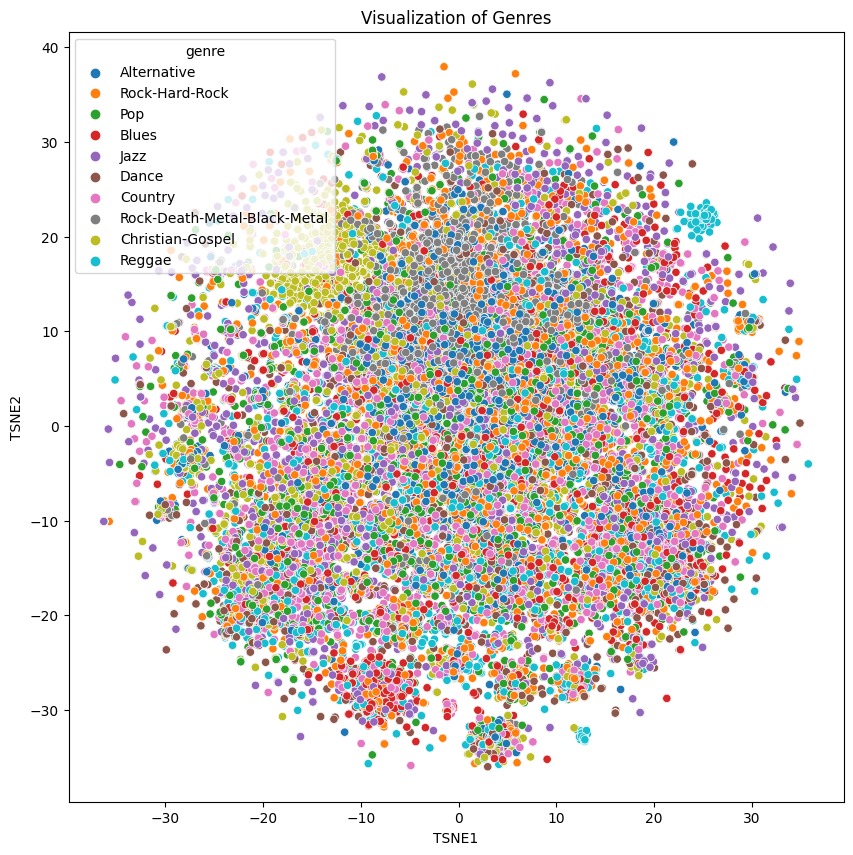

In [17]:
tsne_gensim_2gram = perform_tsne_analysis(X_train_gensim_2gram, X_test_gensim_2gram,
                                    y_train, y_test, plot = True, pickle_ = True,
                                    pickle_dest = '../data/tsne/tsne_gensim_2gram.pickle')

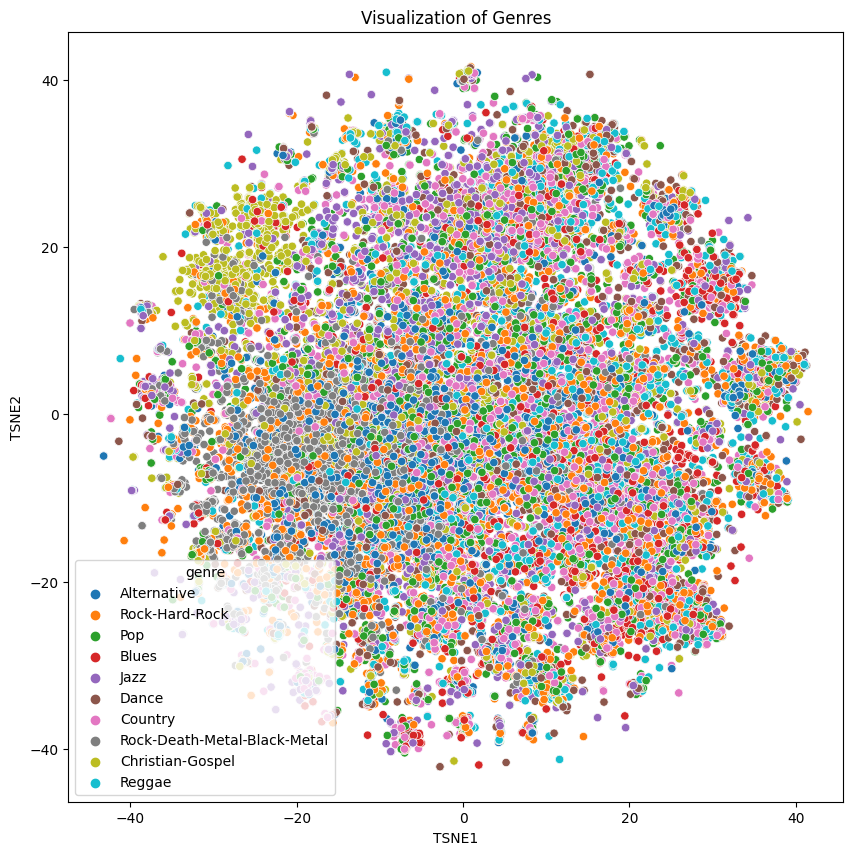

In [18]:
tsne_sklearn_count_unigrams = perform_tsne_analysis(X_train_count_bigrams, X_test_count_bigrams,
                                                    y_train, y_test, plot = True, pickle_ = True,
                                                    pickle_dest = '../data/tsne/tsne_sklearn_count_unigrams.pickle')

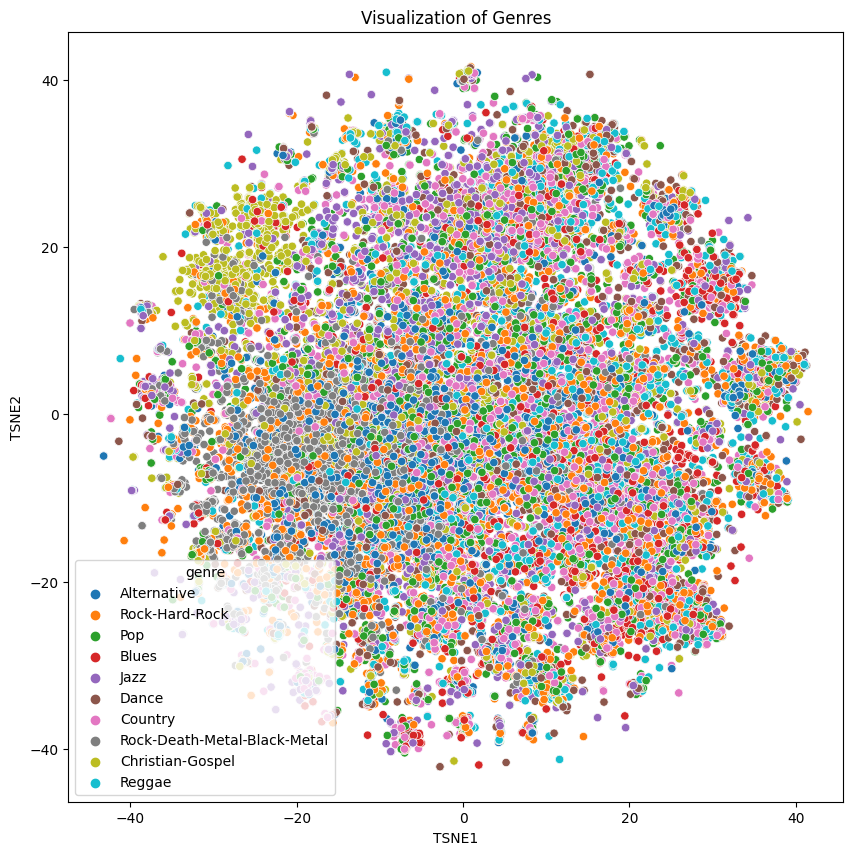

In [19]:
tsne_sklearn_count = perform_tsne_analysis(X_train_count_bigrams, X_test_count_bigrams,
                                           y_train, y_test, plot = True, pickle_ = True,
                                           pickle_dest = '../data/tsne/tsne_sklearn_count_bigrams.pickle')

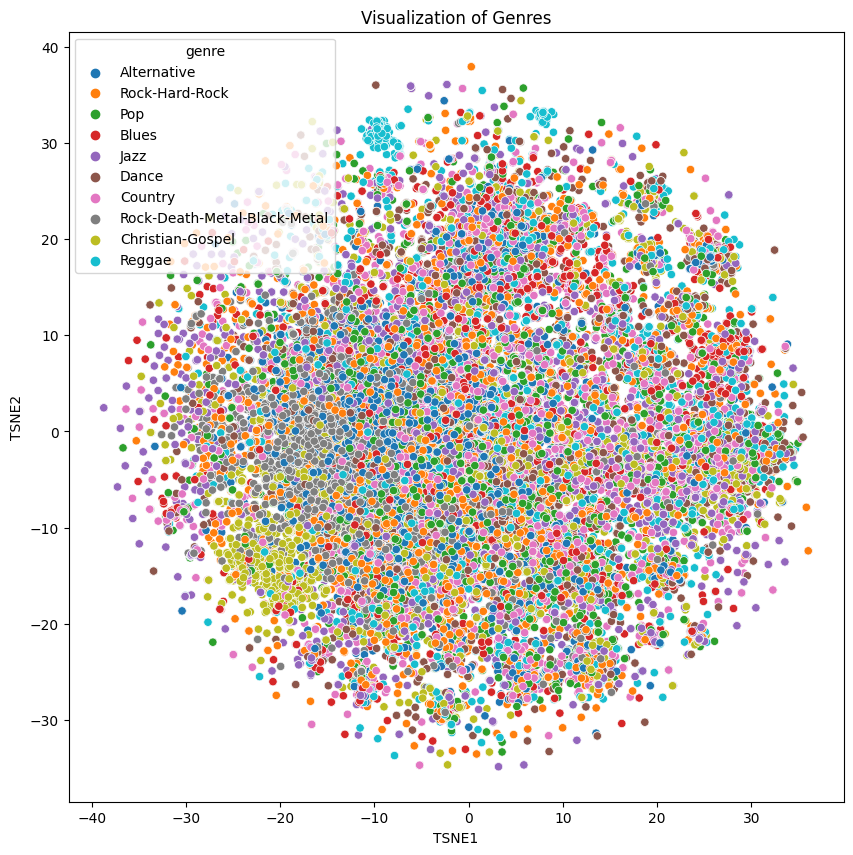

In [8]:
tsne_gensim_3gram = perform_tsne_analysis(X_train_gensim_3gram, X_test_gensim_3gram,
                                    y_train, y_test, plot = True, pickle_ = True,
                                    pickle_dest = '../data/tsne/tsne_gensim_3gram.pickle')

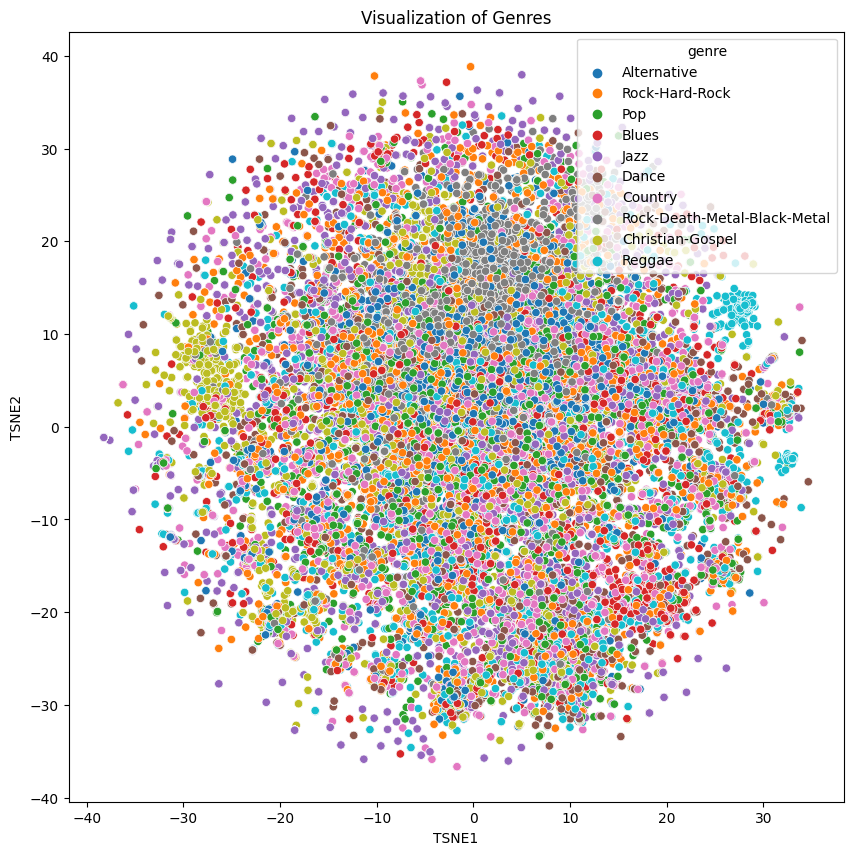

In [8]:
tsne_gensim_4gram = perform_tsne_analysis(X_train_gensim_4gram, X_test_gensim_4gram,
                                    y_train, y_test, plot = True, pickle_ = True,
                                    pickle_dest = '../data/tsne/tsne_gensim_4gram.pickle')